In [1]:
import numpy as np
import tensorflow as tf
import csv
import cv2
import matplotlib.pyplot as plt
from keras.layers import Conv2D, InputLayer, UpSampling2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.viewer import ImageViewer
from skimage.io import imsave
import os

%matplotlib inline

C:\Users\Lenovo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Lenovo\Anaconda3\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


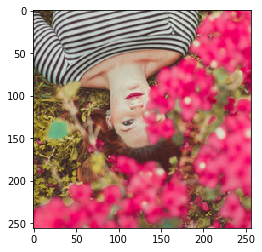

In [2]:
X=[]
for filename in os.listdir('colornet/Train/'):
    X.append((load_img('colornet/Train/'+filename)))
plt.imshow(X[0])
Xt= X

In [3]:
for a in range(int(len(X))):
    X[a]= img_to_array(X[a])
X= np.array(X, dtype= float)
print(X.shape)

(1000, 256, 256, 3)


In [4]:
print(type(X))
split= int(0.95* len(X))
X_train= X[:split, :,:,:]
X_train= 1.0/255* X

<class 'numpy.ndarray'>


In [6]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

In [7]:
model.compile(optimizer='rmsprop', loss='mse')

In [8]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

In [9]:
batch_size = 2
def image_a_b_gen(batch_size):
    for batch in datagen.flow(X_train, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

In [10]:
#TensorBoard(log_dir='/output')
model.fit_generator(image_a_b_gen(batch_size),steps_per_epoch= 5, epochs=50, verbose=1)

Epoch 1/50
5/5 [==============================] - 11s 2s/step - loss: 0.8514
Epoch 2/50
5/5 [==============================] - 10s 2s/step - loss: 0.2030
Epoch 3/50
5/5 [==============================] - 10s 2s/step - loss: 0.0140
Epoch 4/50
5/5 [==============================] - 11s 2s/step - loss: 0.0126
Epoch 5/50
5/5 [==============================] - 10s 2s/step - loss: 0.0123
Epoch 6/50
5/5 [==============================] - 9s 2s/step - loss: 0.0105
Epoch 7/50
5/5 [==============================] - 10s 2s/step - loss: 0.0113
Epoch 8/50
5/5 [==============================] - 10s 2s/step - loss: 0.0110
Epoch 9/50
5/5 [==============================] - 11s 2s/step - loss: 0.0071
Epoch 10/50
5/5 [==============================] - 12s 2s/step - loss: 0.0045
Epoch 11/50
5/5 [==============================] - 10s 2s/step - loss: 0.0135
Epoch 12/50
5/5 [==============================] - 10s 2s/step - loss: 0.0169
Epoch 13/50
5/5 [==============================] - 10s 2s/step - loss: 0.0

In [12]:
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

50/50 [==============================] - 14s 275ms/step
0.010804903986863791


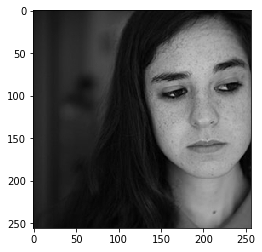

In [63]:
t=[]
for filename in os.listdir('colornet/testdata/Validate'):
    t.append((load_img('colornet/testdata/Validate/'+filename)))
t_raw= t
plt.imshow(t_raw[0])
for i in range(int(len(t))):
    t[i]= img_to_array(t[i])
t= np.array(t, dtype= float)

In [64]:
t1= rgb2lab(1.0/255* t)[:, :, :, 0]
t1= t1.reshape(t1.shape+(1,))

In [65]:
output= model.predict(t1)

In [66]:
output= output*128
cur = np.zeros((256, 256, 3))
cur[:,:,0] = t1[0][:,:,0]
cur[:,:,1:]= output[0]

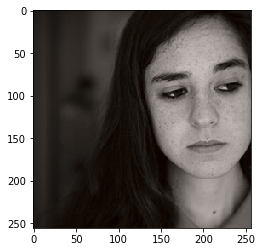

In [67]:
cur= lab2rgb(cur)
plt.imshow(cur)

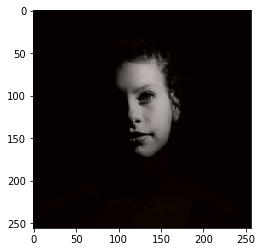

In [69]:
cur[:,:,0]= t1[1][:,:,0]
cur[:,:,1:]= output[1]
cur= lab2rgb(cur)
plt.imshow(cur)